In [24]:
import pandas as pd

df = pd.read_csv('uniranks.csv')
print(df[['Name', 'Year', 'Rank']].head())


                                    Name  Year  Rank
0     California Institute of Technology  2016   1.0
1                   University of Oxford  2016   2.0
2                    Stanford University  2016   3.0
3                University of Cambridge  2016   4.0
4  Massachusetts Institute of Technology  2016   5.0


In [25]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce')
df = df.dropna(subset=['Year', 'Rank', 'Name'])


In [26]:
uni_name = 'University of Oxford'   # Change as needed
df_uni = df[df['Name'] == uni_name].sort_values('Year')

# Prepare X and y
X = df_uni[['Year']]
y = df_uni['Rank']


In [27]:
print(X)
print(y)


       Year
1      2016
800    2017
1781   2018
2884   2019
4142   2020
5539   2021
7065   2022
8727   2023
10526  2024
12430  2025
1        2.0
800      1.0
1781     1.0
2884     1.0
4142     1.0
5539     1.0
7065     1.0
8727     1.0
10526    1.0
12430    1.0
Name: Rank, dtype: float64


In [28]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

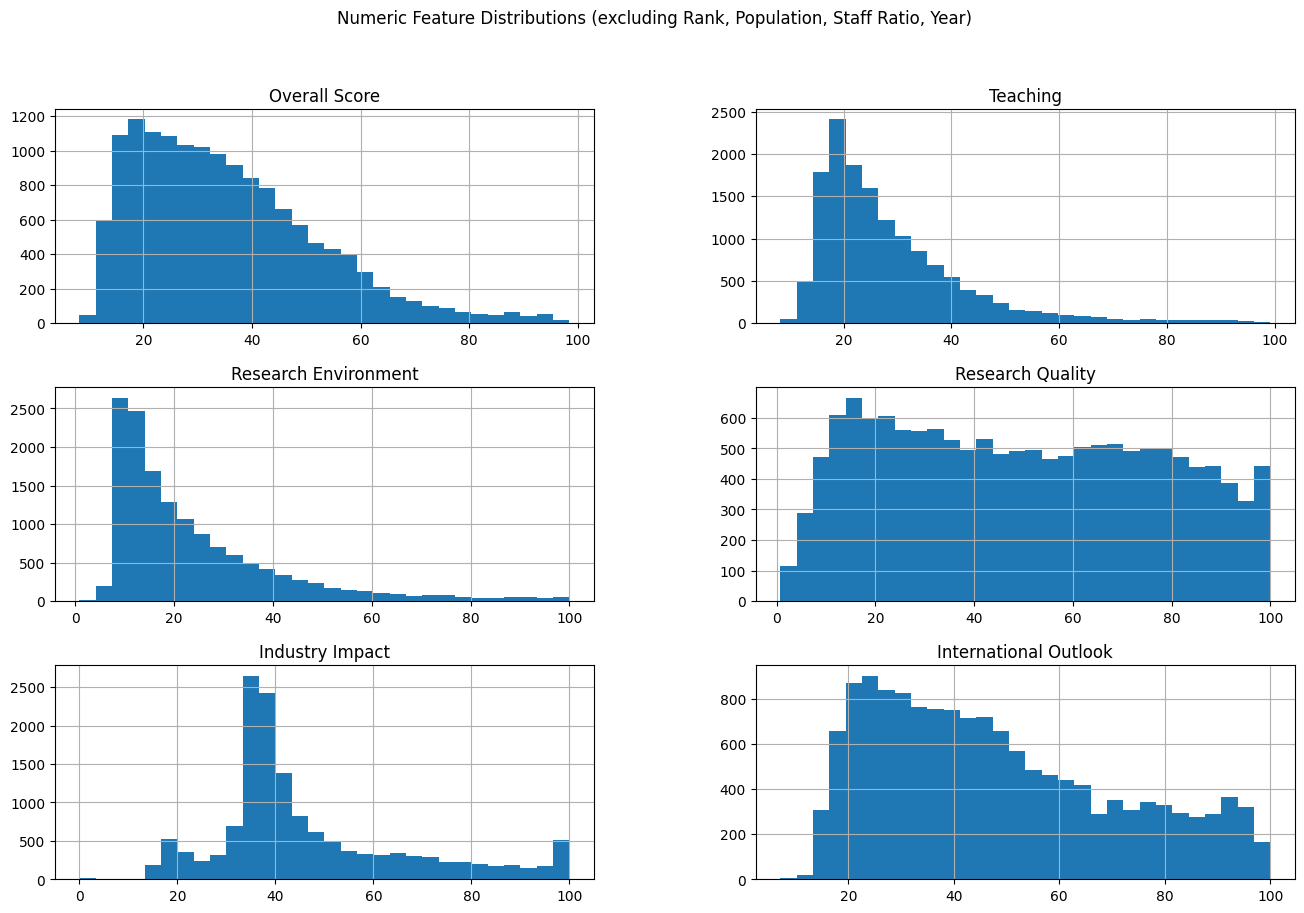

In [29]:
df = pd.read_csv('uniranks.csv')

# List of columns to drop
cols_to_drop = ['Rank', 'Student Population', 'Students to Staff Ratio', 'Year', 'Name']

# Select only numeric columns, then drop the specified ones (if present)
numeric_cols = df.select_dtypes(include='number').columns.tolist()
cols_to_plot = [col for col in numeric_cols if col not in cols_to_drop]

# Plot histograms for the remaining columns
df[cols_to_plot].hist(bins=30, figsize=(16, 10))
plt.suptitle('Numeric Feature Distributions (excluding Rank, Population, Staff Ratio, Year)')
plt.show()

In [30]:
# Columns to exclude
exclude_cols = ['Student Population', 'Students to Staff Ratio', 'Year', 'Name']

# Find all numeric columns, drop excluded
numeric_cols = df.select_dtypes(include='number').columns.tolist()
cols_to_analyze = [col for col in numeric_cols if col not in exclude_cols]

# Correlation with Rank
corr_with_rank = df[cols_to_analyze].corr()['Rank'].drop('Rank').sort_values(key=abs, ascending=False)
print("Correlation with Rank (absolute, descending):\n", corr_with_rank)

Correlation with Rank (absolute, descending):
 Overall Score           -0.848774
Research Quality        -0.807047
Research Environment    -0.710603
Teaching                -0.643042
International Outlook   -0.579548
Industry Impact         -0.498642
Name: Rank, dtype: float64


In [31]:
from sklearn.ensemble import RandomForestRegressor

# Drop excluded columns and rows with missing values in those features
feature_cols = [col for col in cols_to_analyze if col != 'Rank']
df_clean = df.dropna(subset=feature_cols + ['Rank'])

X = df_clean[feature_cols]
y = df_clean['Rank']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
print("\nRandom Forest Feature Importances:\n", feat_importance)



Random Forest Feature Importances:
 Overall Score            0.809475
Industry Impact          0.108456
International Outlook    0.024840
Research Environment     0.021401
Teaching                 0.019161
Research Quality         0.016668
dtype: float64


In [32]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = pd.read_csv('uniranks.csv')

features = [
    'Overall Score',
    'Industry Impact',
    'International Outlook',
    'Research Environment',
    'Teaching'
]

# Drop rows with missing values in these columns
df_vif = df[features].dropna()

# Add constant (intercept) for VIF calculation
X_vif = add_constant(df_vif)


In [33]:
vif = pd.Series(
    [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],
    index=X_vif.columns
)

print("Variance Inflation Factor (VIF):")
print(vif)


Variance Inflation Factor (VIF):
const                    15.172326
Overall Score             7.865758
Industry Impact           1.539367
International Outlook     2.077446
Research Environment      8.418953
Teaching                  5.661547
dtype: float64


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('uniranks.csv')

# Choose only numeric columns and drop NA for selected features + target
features_A = ['Overall Score', 'Industry Impact', 'International Outlook']
features_B = ['Teaching', 'Research Environment', 'Industry Impact', 'International Outlook']
target = 'Rank'

dfA = df[features_A + [target]].dropna()
dfB = df[features_B + [target]].dropna()


In [35]:
# Set a random state for reproducibility
X_A = dfA[features_A]
y_A = dfA[target]
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, random_state=42)

X_B = dfB[features_B]
y_B = dfB[target]
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, random_state=42)


In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error

def eval_model(model, X_train, y_train, X_test, y_test, poly=False):
    if poly:
        polyfeat = PolynomialFeatures(degree=2)
        X_train_poly = polyfeat.fit_transform(X_train)
        X_test_poly = polyfeat.transform(X_test)
        model.fit(X_train_poly, y_train)
        preds = model.predict(X_test_poly)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds), mean_squared_error(y_test, preds)


In [37]:
results = {}

for label, X_train, y_train, X_test, y_test in [
    ("Set_A", X_train_A, y_train_A, X_test_A, y_test_A),
    ("Set_B", X_train_B, y_train_B, X_test_B, y_test_B)
]:
    res = {}
    # Linear Regression
    mae_lr, mse_lr = eval_model(LinearRegression(), X_train, y_train, X_test, y_test)
    res['Linear Regression'] = (mae_lr, mse_lr)
    # Polynomial Regression
    mae_poly, mse_poly = eval_model(LinearRegression(), X_train, y_train, X_test, y_test, poly=True)
    res['Polynomial Regression'] = (mae_poly, mse_poly)
    # Random Forest
    mae_rf, mse_rf = eval_model(RandomForestRegressor(n_estimators=100, random_state=42), X_train, y_train, X_test, y_test)
    res['Random Forest'] = (mae_rf, mse_rf)
    results[label] = res

# Print results in table format
print("Model Comparison (MAE, MSE):")
for set_label, res in results.items():
    print(f"\nFeatures: {set_label.replace('_', ' ')}")
    for model, scores in res.items():
        print(f"{model}: MAE={scores[0]:.2f}, MSE={scores[1]:.2f}")


Model Comparison (MAE, MSE):

Features: Set A
Linear Regression: MAE=208.43, MSE=67720.19
Polynomial Regression: MAE=169.10, MSE=49939.55
Random Forest: MAE=123.58, MSE=34084.45

Features: Set B
Linear Regression: MAE=257.93, MSE=101881.83
Polynomial Regression: MAE=221.49, MSE=80765.98
Random Forest: MAE=185.03, MSE=64640.55


In [38]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import joblib

# Load data
df = pd.read_csv('uniranks.csv')
features = ['Overall Score', 'Industry Impact', 'International Outlook']
target = 'Rank'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# Train Random Forest only on selected features
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Save this model
joblib.dump(rf, "rf_rank_predictor.pkl")


['rf_rank_predictor.pkl']